In [10]:
!pip install razdel
!pip install pymorphy2

In [11]:
import json
import re
import requests
from tqdm.notebook import tqdm
import razdel
import nltk
nltk.download('stopwords')
import pymorphy2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing  import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score
from IPython.core.display import HTML, display

SEED = 42
TOKEN_PATTERN = "[а-яё]+"

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/tmp/ipykernel_33/1234924667.py:23: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


In [12]:
train_df = pd.read_csv("/kaggle/input/sites18/train18.csv")

train_df.head()

,ID,url,title,label
0,0,m.kp.md,"Экс-министр экономики Молдовы - главе МИДЭИ, ц...",0
1,1,www.kp.by,Эта песня стала известна многим телезрителям б...,0
2,2,fanserials.tv,Банши 4 сезон 2 серия Бремя красоты смотреть о...,0
3,3,colorbox.spb.ru,Не Беси Меня Картинки,0
4,4,tula-sport.ru,В Новомосковске сыграют следж-хоккеисты алекси...,0


In [13]:
test_df = pd.read_csv("/kaggle/input/sites18/test18.csv")

test_df.head()

,ID,url,title
0,135309,www.kommersant.ru,Шестой кассационный суд в Самаре начнет работу...
1,135310,urexpert.online,"Что такое индексация алиментов, кем и в каких ..."
2,135311,imperimeha.ru,Женщинам | Империя Меха - Part 12
3,135312,national-porn.com,"Небритые, волосатые киски: Порно всех стран и ..."
4,135313,2gis.ru,67


In [14]:
from sklearn.metrics import f1_score

# Предобработка данных

Сначала обработаем датасет
Посмотрим на значения, обработаем пропуски

In [15]:
train_df.shape , test_df.shape

((135309, 4), (165378, 3))

In [16]:
train_df.describe()

,ID,label
count,135309.000000,135309.000000
mean,67654.000000,0.123532
std,39060.488124,0.329048
min,0.000000,0.000000
25%,33827.000000,0.000000
50%,67654.000000,0.000000
75%,101481.000000,0.000000
max,135308.000000,1.000000


In [17]:
train_df.isna().sum()

ID       0
url      0
title    1
label    0
dtype: int64

In [18]:
train_df[train_df['title'].isna()]

,ID,url,title,label
78497,78497,jpg-1.com,NaN,0


In [19]:
train_df.dropna(axis=0, inplace=True)


In [20]:
train_df.isna().sum()

ID       0
url      0
title    0
label    0
dtype: int64

In [21]:
test_df.isna().sum()

ID       0
url      0
title    0
dtype: int64

In [22]:
train_df.set_index('ID',drop=True, inplace=True)
test_df.set_index('ID',drop=True, inplace=True)

In [23]:
train_df.head()


,url,title,label
ID,,,
0,m.kp.md,"Экс-министр экономики Молдовы - главе МИДЭИ, ц...",0
1,www.kp.by,Эта песня стала известна многим телезрителям б...,0
2,fanserials.tv,Банши 4 сезон 2 серия Бремя красоты смотреть о...,0
3,colorbox.spb.ru,Не Беси Меня Картинки,0
4,tula-sport.ru,В Новомосковске сыграют следж-хоккеисты алекси...,0


In [24]:
class_balance = train_df['label'].value_counts()
class_balance

label
0    118593
1     16715
Name: count, dtype: int64

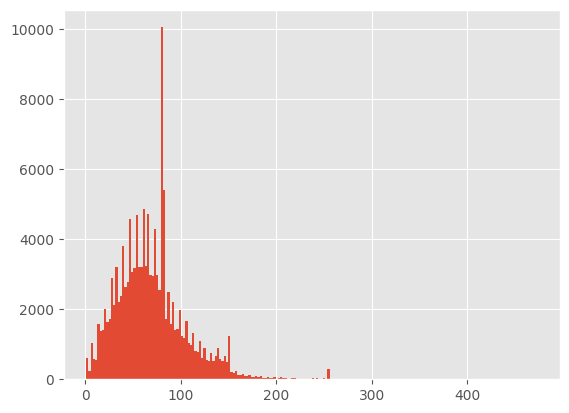

In [25]:
train_df.title.str.len().hist(bins=200);

# Кодирование текстов и обучение модели




добавил словари стоп-слов, чтобы те не влияли негативно на предсказания модели

In [26]:
stopwords_title= list(nltk.corpus.stopwords.words('russian'))
len(stopwords_title)

151

In [27]:
stopwords_url= list(nltk.corpus.stopwords.words('english'))

# Модель RandomForest

Сначала попробовал RandomForest - достаточно сильную модель для классификации

In [28]:
X = train_df['title'] # предсказываю только на title
y = train_df['label']

In [29]:
X_train,X_val, y_train, y_val = train_test_split(X,y,random_state=SEED)

In [ ]:
forest_model = Pipeline([
    (
        
        'vectorizer',
        TfidfVectorizer(
            lowercase=True, ngram_range=(1, 1), token_pattern=TOKEN_PATTERN,
            stop_words=stopwords_title, min_df=3, max_df=0.8
        )
    ),
    ('clf', RandomForestClassifier(random_state=SEED))
])

In [ ]:
forest_model.fit(X_train, y_train)

In [ ]:
f1_score(y_train, forest_model.predict(X_train))

In [ ]:
f1_score(y_val, forest_model.predict(X_val))

Случайный лес, на удивление, показал себя плохо

# Модель с SGD классификатором

Продолжил с простой модели с семинара, кодировал только 'title'

In [30]:
char_tfidf_model = Pipeline([
    (
        'vectorizer',
        TfidfVectorizer(
            lowercase=True, ngram_range=(2, 4), analyzer='char',
             min_df=5, max_df=0.8
        )
    ),
    ('clf', SGDClassifier(random_state=SEED, loss='log_loss', class_weight='balanced'))
])

In [31]:
char_tfidf_model.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer='char', max_df=0.8, min_df=5,
                                 ngram_range=(2, 4))),
                ('clf',
                 SGDClassifier(class_weight='balanced', loss='log_loss',
                               random_state=42))])

In [32]:
f1_score(y_train, char_tfidf_model.predict(X_train))

0.9147477859068156

In [33]:
f1_score(y_val, char_tfidf_model.predict(X_val))

0.9053356282271944

In [34]:
res_SGD_classifier = char_tfidf_model.predict(test_df['title'])

In [35]:
final_SGD=pd.DataFrame({'ID': test_df.index.to_numpy() ,'label' : res_SGD_classifier })
final_SGD.set_index('ID', inplace=True)

In [36]:
final_SGD.to_csv('eval_SGD.csv')

Очень хорошие результаты показал данный классификатор. Изучив его получше, я понял, что loss='log_loss' значит, что мы используем логистическую регрессию. Так что дальше буду использовать ее как отдельный класс из sklearn

# Модель с логистической регрессией

попробуем лемматизатор и/или стеммер

Как выяснилось позже - модель с лемматизатором выбивала намного больший скор. Оставим его


In [70]:
lemmatizer = pymorphy2.MorphAnalyzer()

In [56]:
stemmer_title = nltk.stem.SnowballStemmer('russian')
stemmer_url = nltk.stem.SnowballStemmer('english')

In [23]:
#функция для предобработки слов
def lemmatize(token):
    lemmatizer_cache = {}
    if lemmatizer.word_is_known(token):
        if token not in lemmatizer_cache:
            lemmatizer_cache[token] = lemmatizer.parse(token)[0].normal_form
        return lemmatizer_cache[token]
    return token

In [83]:
model_logreg = Pipeline([
    (
        'features',
        ColumnTransformer([
            
            
            ('url',
             
#               CountVectorizer(    # более слабый инструмент
#                     lowercase=True, ngram_range=(1, 1),
#                     stop_words=stopwords_url, min_df=3, max_df=0.75
             TfidfVectorizer(
            lowercase=True, ngram_range=(2,4), analyzer='char', # деление на части слов дает лучший результат, чем деление на униграммы
             min_df=5, max_df=0.8 , preprocessor = lemmatize
                ),                     
             'url'
            ),
            
            
            (
                'title',
            TfidfVectorizer(
            lowercase=True, ngram_range=(2,4), analyzer='char',
             min_df=5, max_df=0.8, stop_words=stopwords_title, preprocessor= lemmatize
        ),
            'title'
            ),
            
            
            
        ])
    ),
    ('clf', LogisticRegression(max_iter = 200, random_state=SEED, solver='lbfgs', class_weight='balanced', penalty =  "l2"))
])

С помощью gridSearchCV выполнял поиск по сетке для получения лучших гиперпараметров модели

In [33]:
param_grid = {
    'features__url__ngram_range': [(2, 4), (3, 5)],
    'features__title__ngram_range': [(2, 4), (3, 5)],
#     'features__url__min_df': (3, 5, 7),
#     'features__url__max_df': (0.5, 0.70, 0.8),
#     'features__title__min_df': (3, 5, 7),
#     'features__title__max_df': (0.5, 0.70, 0.8)
}
grid_search_logreg = GridSearchCV(model_logreg,param_grid)

In [84]:
X_train_logreg,X_val_logreg, y_train_logreg, y_val_logreg = train_test_split(train_df[['url','title']],train_df['label'],
                                                                                     train_size = 0.8, random_state=SEED)

In [38]:
# grid_search_logreg.fit(X_train_logreg, y_train_logreg)


In [37]:
# grid_search_logreg.best_params_

In [85]:
model_logreg.fit(X_train_logreg, y_train_logreg)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('url',
                                                  TfidfVectorizer(analyzer='char',
                                                                  max_df=0.8,
                                                                  min_df=5,
                                                                  ngram_range=(2,
                                                                               4),
                                                                  preprocessor=<function lemmatize at 0x7a7ffd28be20>),
                                                  'url'),
                                                 ('title',
                                                  TfidfVectorizer(analyzer='char',
                                                                  max_df=0.8,
                                                                  min_df=5,
                                                                  ngram_range=(2,
                                                                               4),
                                                                  preprocessor=<function lemmatize at 0x7a7ffd28be20>,
                                                                  stop_words=['и',
                                                                              'в',
                                                                              'во',
                                                                              'не',
                                                                              'что',
                                                                              'он',
                                                                              'на',
                                                                              'я',
                                                                              'с',
                                                                              'со',
                                                                              'как',
                                                                              'а',
                                                                              'то',
                                                                              'все',
                                                                              'она',
                                                                              'так',
                                                                              'его',
                                                                              'но',
                                                                              'да',
                                                                              'ты',
                                                                              'к',
                                                                              'у',
                                                                              'же',
                                                                              'вы',
                                                                              'за',
                                                                              'бы',
                                                                              'по',
                                                                              'только',
                                                                              'ее',
                                                                              'мне', ...]),
                                                  'title')])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=200,
                                    random_state=42))])

In [86]:
f1_score(
    y_train_logreg,
    model_logreg.predict(X_train_logreg)
)

0.9927525403466826

In [87]:
f1_score(
    y_val_logreg,
    model_logreg.predict(X_val_logreg)
)


0.9801324503311258

In [88]:
result_logreg=model_logreg.predict(test_df[['url', 'title']])

In [89]:
final_logreg=pd.DataFrame({'ID': test_df.index.to_numpy() ,'label' : result_logreg })
final_logreg.set_index('ID', inplace=True)

In [90]:
final_logreg.to_csv('eval_LogisticRegression.csv')

Вывод:
Логистическая регрессия + лемматизация + tf-idf выдает хороший результат для данной задачи